In [2]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from torch import nn

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# import torchvision
from torchvision import datasets
from torchvision import transforms

# import torchmetrics
# from torchmetrics import ConfusionMatrix
from sklearn.metrics import confusion_matrix

from pathlib import Path
import os
import random
from PIL import Image

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import numpy as np
# import splitfolders
import pandas as pd

from torchinfo import summary

from timeit import default_timer as timer

# Spliting folders

In [ ]:
# input_folder = 'animals'
# splitfolders.ratio(
#     input_folder, 
#     output="Dataset",
#     seed=0,
#     ratio=(0.9, 0.1),
#     move=True,
#     group_prefix=None
# )

Copying files: 0 files [00:00, ? files/s]


# Info about classes

In [5]:
def get_lengths(dir_path):
    dataset_info = {}
    for dirpath, dirnames, filenames in os.walk(dir_path):
        animal_name = dirpath.split('/')[-1]
        dataset_info[animal_name] = [len(filenames)]
    del dataset_info[dir_path.split('/')[-1]]
    return dataset_info

train_info = get_lengths('/content/drive/MyDrive/Colab Notebooks/Animals-10/Dataset/train')
val_info = get_lengths('/content/drive/MyDrive/Colab Notebooks/Animals-10/Dataset/val')

In [6]:
train_dir = "/content/drive/MyDrive/Colab Notebooks/Animals-10/Dataset/train"
val_dir = "/content/drive/MyDrive/Colab Notebooks/Animals-10/Dataset/val"

In [7]:
train_info = pd.DataFrame(train_info, index=['train'])
val_info = pd.DataFrame(val_info, index=['val'])
train_val_info = pd.concat([train_info, val_info]).T
train_val_info['sum'] = train_val_info['train'] + train_val_info['val']

In [8]:
train_val_info = train_val_info.sort_values(by='sum', ascending=False)

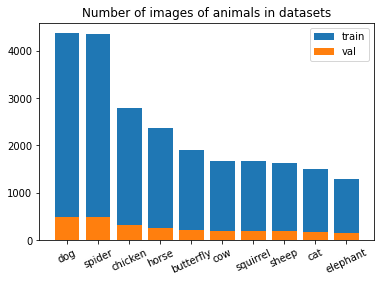

In [9]:
plt.figure(figsize=(6, 4))
plt.bar(train_val_info.index, train_val_info['train'], label='train')
plt.bar(train_val_info.index, train_val_info['val'], label='val')
plt.legend()
plt.title('Number of images of animals in datasets')
plt.xticks(rotation=25);

## Getting random image

Random image path: /content/drive/MyDrive/Colab Notebooks/Animals-10/Dataset/train/spider/OIP--8CNJSaiNQEfqsZDtw-TvQAAAA.jpeg
Random image class: spider
Image height: 200
Image width: 236


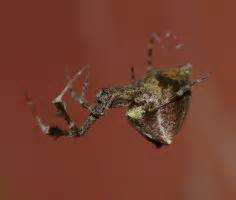

In [11]:
def show_random_image(images_path,
                      seed=None):
    """
    Shows one random photo with details such as class, heigh, width
    """
    
    if seed:
        random.seed(seed)

    random_image_path = random.choice(images_path)
    image_class = random_image_path.parent.stem
    image = Image.open(random_image_path)
    print(f"Random image path: {random_image_path}")
    print(f"Random image class: {image_class}")
    print(f"Image height: {image.height}")
    print(f"Image width: {image.width}")
    return image

input_folder = Path('/content/drive/MyDrive/Colab Notebooks/Animals-10/Dataset')
image_path_list = list(input_folder.glob("*/*/*"))
show_random_image(image_path_list, 0)

# Transformation

In [93]:
train_transform = transforms.Compose([
     transforms.Resize(size=(224, 224)),
     transforms.RandomHorizontalFlip(),
    #  transforms.RandomRotation(90),
     transforms.ToTensor(),
    #  transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

val_transform = transforms.Compose([
     transforms.Resize(size=(224, 224)),
     transforms.ToTensor(),
    #  transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

# Showing transformed image

In [13]:
import torch

In [94]:
def show_random_transformed_image(images_path, 
                                  transform,
                                  n_images=5, 
                                  seed=None):

    for i in range(n_images):
        orig_image = show_random_image(images_path=images_path,
                                       seed=seed)

        transformed_image = transform(orig_image).permute(1, 2, 0)

        plt.subplot(121)
        plt.imshow(orig_image)
        plt.title('Original image')
        plt.axis('off')
        
        plt.subplot(122)
        plt.imshow(transformed_image)
        plt.title('Transformed image')
        plt.axis('off')

        plt.show()
        print()

Random image path: /content/drive/MyDrive/Colab Notebooks/Animals-10/Dataset/train/cat/ea36b60b2bf5053ed1584d05fb1d4e9fe777ead218ac104497f5c978a7eebdbb_640.jpg
Random image class: cat
Image height: 426
Image width: 640


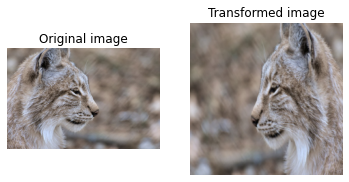


Random image path: /content/drive/MyDrive/Colab Notebooks/Animals-10/Dataset/train/spider/OIP-w1CpIivfTR4DhAVW0q6aoAHaFj.jpeg
Random image class: spider
Image height: 225
Image width: 300


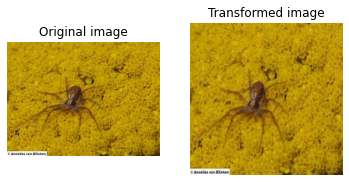


Random image path: /content/drive/MyDrive/Colab Notebooks/Animals-10/Dataset/train/butterfly/OIP-kxM6as4M2lDkykh2hAL2XAHaFj.jpeg
Random image class: butterfly
Image height: 225
Image width: 300


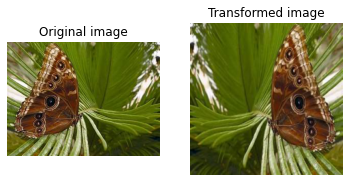

In [95]:
show_random_transformed_image(image_path_list, train_transform, 3)

# Data preparation

In [96]:
train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root=val_dir,
    transform=val_transform)

In [97]:
batch_size=8

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
    )

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
    )

# EfficientNetV2 S was too big, so i chose simple vgg16

In [18]:
import torchvision

In [98]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [135]:
weights = torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
auto_transforms = weights.transforms()


model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

## Model info

In [136]:
summary(
    model=model,
    input_size=(batch_size, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [8, 3, 224, 224]     [8, 1000]            --                   True
├─Sequential (features)                                      [8, 3, 224, 224]     [8, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [8, 3, 224, 224]     [8, 24, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [8, 3, 224, 224]     [8, 24, 112, 112]    648                  True
│    │    └─BatchNorm2d (1)                                  [8, 24, 112, 112]    [8, 24, 112, 112]    48                   True
│    │    └─SiLU (2)                                         [8, 24, 112, 112]    [8, 24, 112, 112]    --                   --
│    └─Sequential (1)                                        [8, 24, 112, 112]    [8, 24, 112,

## Freezing features

In [137]:
for param in model.features.parameters():
    param.requires_grad = False

In [138]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [139]:
output_shape = len(train_dataset.classes)

num_features = model.classifier[1].in_features
features = list(model.classifier.children())[:-1]
features.extend([nn.Linear(num_features, output_shape)])
model.classifier = nn.Sequential(*features)

summary(
    model=model,
    input_size=(batch_size, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [8, 3, 224, 224]     [8, 10]              --                   Partial
├─Sequential (features)                                      [8, 3, 224, 224]     [8, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [8, 3, 224, 224]     [8, 24, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [8, 3, 224, 224]     [8, 24, 112, 112]    (648)                False
│    │    └─BatchNorm2d (1)                                  [8, 24, 112, 112]    [8, 24, 112, 112]    (48)                 False
│    │    └─SiLU (2)                                         [8, 24, 112, 112]    [8, 24, 112, 112]    --                   --
│    └─Sequential (1)                                        [8, 24, 112, 112]    [8, 2

# Train loop

In [144]:
def train_step(model, 
               dataloader, 
               loss_function, 
               optimizer, 
               device):
    
    model.train()
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X) #.permute(1, 2, 0)
        loss = loss_function(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y)
        
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    
    return train_loss, train_acc

In [141]:
def val_step(model, 
             dataloader,
             loss_function, 
             device):
    
    model.eval()
    val_loss, val_acc = 0, 0
    y_preds = []
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X) #.permute(1, 2, 0)
            loss = loss_function(y_pred, y)
            val_loss += loss.item()
            
            y_pred_class = torch.argmax(y_pred, dim=1)
            val_acc += (y_pred_class == y).sum().item() / len(y)
            
            y_preds.append(y_pred_class.cpu())
            
    val_loss /= len(dataloader)
    val_acc /= len(dataloader)
    
    y_pred_tensor = torch.cat(y_preds)
    return val_loss, val_acc, y_pred_tensor

In [145]:
def train(model, 
          train_dataloader,
          val_dataloader,
          loss_function,
          optimizer,
          epochs,
          device):
    
    results = {'train_loss': [], 
               'train_acc': [], 
               'val_loss': [], 
               'val_acc': []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model, 
                                           dataloader=train_dataloader,
                                           loss_function=loss_function,
                                           optimizer=optimizer,
                                           device=device)
        
        val_loss, val_acc, y_preds = val_step(model=model, 
                                              dataloader=val_dataloader,
                                              loss_function=loss_function,
                                              device=device)
        
        print(f'Epoch: {epoch+1}: , Train loss: {train_loss:.3f}, Validation loss: {val_loss:.3f}')
        print(f'Train accuracy: {train_acc:.3f}, Validation accuracy: {val_acc:.3f}')
        
        results['train_loss'].append(train_loss)
        results['val_loss'].append(val_loss)
        results['train_acc'].append(train_acc)
        results['val_acc'].append(val_acc)
        
        return results, y_preds

# Running model

In [146]:
torch.cuda.manual_seed(0)
torch.manual_seed(0)

epochs = 10

loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

start_timer = timer()

model_results, preds = train(model=model, 
                             train_dataloader=train_dataloader,
                             val_dataloader=val_dataloader,
                             loss_function=loss_function,
                             optimizer=optimizer,
                             epochs=epochs,
                             device=device)

end_timer = timer()

print(f'Total learning time: {(end_timer - start_timer):.3f}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1: , Train loss: 0.386, Validation loss: 941.016
Train accuracy: 0.888, Validation accuracy: 0.928
Total learning time: 230.487


# Saving model

In [202]:
PATH = '/content/drive/MyDrive/Colab Notebooks/Animals-10/'

# torch.save(model.state_dict(), PATH+'effnet_trained')
torch.save(model, PATH+'model_effnet.pt')

# Loss & accuracy 

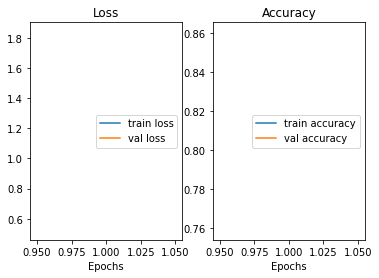

In [124]:
plt.subplot(121)
plt.plot(len(model_results['train_loss']), model_results['train_loss'], label='train loss')
plt.plot(len(model_results['val_loss']), model_results['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(122)
plt.plot(len(model_results['train_acc']), model_results['train_acc'], label='train accuracy')
plt.plot(len(model_results['val_acc']), model_results['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()

# Confusion maxtrix

In [199]:
def check_test(path, transform, model, device, class_names):
  image = Image.open(path)
  tr_image = transform(image).view((1, 3, 224, 224)).to(device) #.permute(1, 2, 0)
  y_pred = model(tr_image)
  lst = torch.softmax(y_pred, dim=1).cpu().detach().numpy().flatten()
  lst = list(map(lambda x: f"{np.round(100*x, 2)} %", lst))
  print(len(lst))
  preds = pd.DataFrame({'class': class_names, 'probabilty': lst}).sort_values(by='probability', ascending=False)


  fig = plt.figure()
  plt.imshow(image)
  plt.axis('off')
  plt.close(fig)

  display(fig, preds)

10


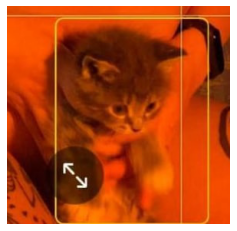

,class,probabilty
0,butterfly,2.35 %
1,cat,82.96 %
2,chicken,2.66 %
3,cow,2.73 %
4,dog,4.61 %
5,elephant,0.64 %
6,horse,1.76 %
7,sheep,0.18 %
8,spider,2.0 %
9,squirrel,0.11 %


In [200]:
check_test('photo_2022-11-24_20-12-23.jpg', val_transform, model, device, val_dataset.classes)

In [204]:
print(val_dataset.classes)

['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
